In [1]:
from simple_tritium_transport_model import Model, ureg, quantity_to_activity

ureg.define("T = 1 * particle")
ureg.define("n = 1 * particle")

baby_model = Model(radius=8 * ureg.cm, height= 5 * ureg.cm, TBR=1e-3*ureg.T * ureg.n**-1)

1.0053096491487339 liter


In [2]:
baby_model.exposure_time = 12 * ureg.h
baby_model.dt = baby_model.exposure_time/100
print(f"Salt volume: {baby_model.volume.to(ureg.L):.2f~P}")
print(f"TBR: {baby_model.TBR.to(ureg.dimensionless):.4f~P}")

baby_model.number_days = 2 * ureg.days
baby_model.neutron_rate = 1.2e8 * ureg.neutron * ureg.s**-1
baby_model.run(t_final=7*ureg.day)

Salt volume: 1.01 l
TBR: 0.0010


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [3]:
wall_release = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations))
top_release = quantity_to_activity(baby_model.Q_top(baby_model.concentrations))
flow_rate_wall = 100 * ureg.mL * ureg.min**-1
flow_rate_top = 600 * ureg.mL * ureg.min**-1

wall_sweep_concentration = wall_release / flow_rate_wall
top_sweep_concentration = top_release / flow_rate_top

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


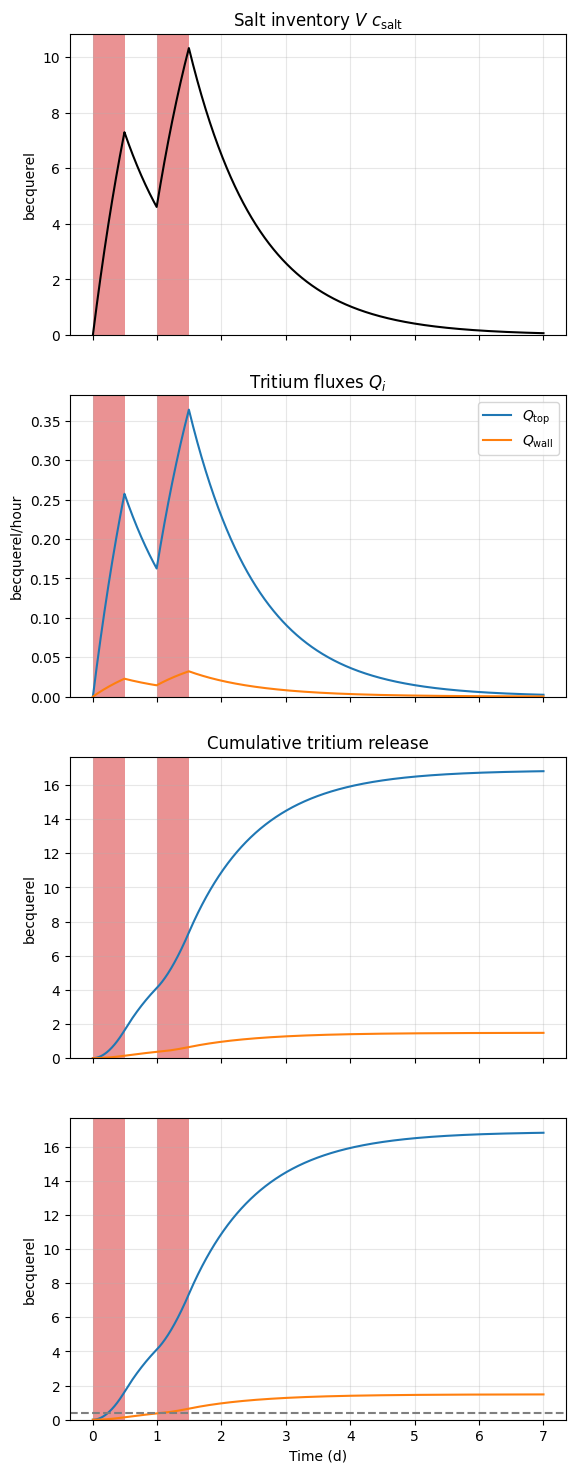

In [4]:
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul, ax_sample_act) = plt.subplots(4, 1, sharex=True, figsize=(6.4, 18))
plt.sca(ax_inv)
plt.title("Salt inventory $V \ c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes $Q_i$")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="$Q_\mathrm{top}$")
plt.plot(time, release_walls, label="$Q_\mathrm{wall}$")
plt.legend()

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = (
    cumulative_trapezoid(
        release_top.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        release_walls.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")

plt.sca(ax_sample_act)
ax_sample_act.yaxis.set_units(ureg.Bq)

collection_vial_volume = 10 * ureg.mL
lsc_vial_water_volume = 10 * ureg.mL
plt.plot(time, integrated_top * lsc_vial_water_volume / collection_vial_volume)
plt.plot(time, integrated_wall * lsc_vial_water_volume / collection_vial_volume)

plt.axhline(y=0.4 * ureg.Bq, color="tab:grey", linestyle="dashed")

plt.xlabel(f"Time ({time.units:~P})")



for ax in [ax_inv, ax_fluxes, ax_cumul, ax_sample_act]:
    if ax.yaxis.get_scale() == "linear":
        ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(0*ureg.h + day*ureg.day, baby_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)

plt.savefig("basic_model_results.pdf")
plt.show()

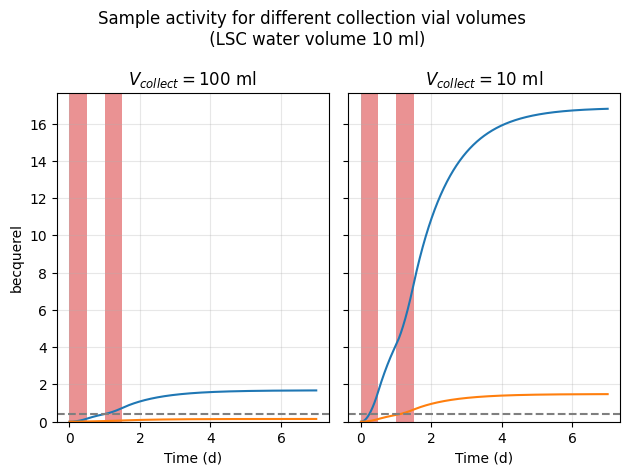

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True)
LSC_VIAL_WATER_VOLUME = 10 * ureg.mL
plt.suptitle(f"Sample activity for different collection vial volumes \n (LSC water volume {LSC_VIAL_WATER_VOLUME: ~P})")
for ax, collection_vial_volume in zip(axs, [100 * ureg.mL, 10*ureg.mL]):
    ax.yaxis.set_units(ureg.Bq)

    ax.plot(time, integrated_top * LSC_VIAL_WATER_VOLUME / collection_vial_volume)
    ax.plot(time, integrated_wall * LSC_VIAL_WATER_VOLUME / collection_vial_volume)

    ax.axhline(y=0.4 * ureg.Bq, color="tab:grey", linestyle="dashed")

    ax.set_xlabel(f"Time ({time.units:~P})")
    ax.grid(alpha=0.3)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(0*ureg.h + day*ureg.day, baby_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)
    ax.set_title(f"$V_{{collect}} = {collection_vial_volume: ~L}$")
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()